In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from IPython.display import display
import requests
import seaborn as sns
import csv
import json
import fiona


import geopandas as gpd
from matplotlib.colors import LinearSegmentedColormap

import warnings
warnings.filterwarnings('ignore')


## Luis

In [2]:
csvpath = os.path.join("csv-data", "anxiety-depression-data.csv")

df = pd.read_csv(csvpath)

by_state_df = df[(df['State'] != 'United States') & 
                (df['Group'] == 'By State') & 
                (df['Indicator'] == 'Symptoms of Anxiety Disorder or Depressive Disorder')]
by_state_df['date_column'] = pd.to_datetime(by_state_df['Time Period Start Date'], format='%m/%d/%Y')
by_state_df['Year'] = by_state_df['date_column'].dt.year

state_mean_df = by_state_df.groupby('State')['Value'].mean()
had_states_val = state_mean_df.nlargest(3)
lad_states_val = state_mean_df.nsmallest(3)


lad_states = lad_states_val.index
had_states = had_states_val.index

In [3]:
json_path = os.path.join('csv-data', 'gz_2010_us_040_00_500k.json')
us_states = gpd.read_file(json_path)

us_states['State'] = us_states['NAME']
us_states = us_states.drop(columns=['NAME']).loc[(us_states['State'] != 'Alaska') 
                                                & (us_states['State'] != 'Hawaii')]
merged_df = us_states.merge(state_mean_df, on='State')

fig, ax = plt.subplots(1, 1, figsize=(20, 20))

color1 = 'lightskyblue'
color2 = 'lightcoral'
cmap = LinearSegmentedColormap.from_list('custom_cmap', [color1, color2])
merged_df.plot(column='Value', cmap=cmap, linewidth=0.8, ax=ax, edgecolor='0.8', legend='true')

plt.title('Levels of Anxiety and Depression Across the United States for 2020-2023', fontsize=20)
plt.show()

DriverError: csv-data\gz_2010_us_040_00_500k.json: No such file or directory

In [ ]:
census_csv = os.path.join('csv-data', '2022-census.csv')
census_df = pd.read_csv(census_csv)
drop_columns = ['SUMLEV', 'ESTIMATESBASE2020', 'REGION', 'STATE', 'DIVISION']
population_df = census_df[census_df['NAME'].isin(lad_states + had_states)].drop(columns=drop_columns)

south_dakota_row = census_df[census_df['NAME'] == 'South Dakota']
minnesota_row = census_df[census_df['NAME'] == 'Minnesota']
north_dakota_row = census_df[census_df['NAME'] == 'North Dakota']

louisiana_row = census_df[census_df['NAME'] == 'Louisiana']
mississippi_row = census_df[census_df['NAME'] == 'Mississippi']
oklahoma_row = census_df[census_df['NAME'] == 'Oklahoma']

south_dakota_average_population = south_dakota_row[['POPESTIMATE2020', 'POPESTIMATE2021', 'POPESTIMATE2022']].astype(int).mean(axis=1)
south_dakota_pop = round(south_dakota_average_population.values[0])

minnesota_average_population = minnesota_row[['POPESTIMATE2020', 'POPESTIMATE2021', 'POPESTIMATE2022']].astype(int).mean(axis=1)
minnesota_pop = round(minnesota_average_population.values[0])

north_dakota_average_population = north_dakota_row[['POPESTIMATE2020', 'POPESTIMATE2021', 'POPESTIMATE2022']].astype(int).mean(axis=1)
north_dakota_pop = round(north_dakota_average_population.values[0])

louisiana_average_population = louisiana_row[['POPESTIMATE2020', 'POPESTIMATE2021', 'POPESTIMATE2022']].astype(int).mean(axis=1)
lousiana_pop = round(louisiana_average_population.values[0])

mississippi_average_population = mississippi_row[['POPESTIMATE2020', 'POPESTIMATE2021', 'POPESTIMATE2022']].astype(int).mean(axis=1)
mississippi_pop = round(mississippi_average_population.values[0])

oklahoma_average_population = oklahoma_row[['POPESTIMATE2020', 'POPESTIMATE2021', 'POPESTIMATE2022']].astype(int).mean(axis=1)
oklahoma_pop = round(oklahoma_average_population.values[0])

##----##
pop = {'State Name' : ['Louisiana', 'Mississippi', 'Oklahoma', 'South Dakota', 'Minnesota',  'North Dakota'],
              'Population' : [lousiana_pop, mississippi_pop, oklahoma_pop, south_dakota_pop, minnesota_pop, north_dakota_pop]}

In [ ]:
#Import data sets
#Create Paths
unin_2019_path =  os.path.join('csv-data', '2019-unisured-pop-data.csv')
unin_2021_path =  os.path.join('csv-data', '2021-unisured-pop-data.csv')
unin_2022_path =  os.path.join('csv-data', '2022-unisured-pop-data.csv')
overdose_path =  os.path.join('csv-data', 'VSRR_Provisional_Drug_Overdose_Death_Counts.csv')
death_path =  os.path.join('csv-data', 'Weekly_Counts_of_Death_by_Jurisdiction_and_Select_Causes_of_Death.csv')

#Import .csv files into Panda Data Frames
unin_2019_full_df =  pd.read_csv(unin_2019_path)
unin_2021_full_df =  pd.read_csv(unin_2021_path)
unin_2022_full_df =  pd.read_csv(unin_2022_path)
overdose_full_df = pd.read_csv(overdose_path)
death_full_df = pd.read_csv(death_path)

## Analysis of Causes of Death for States with Highest and Lowest Indices of Anxiety and Depression

In [ ]:
# Clean full data set and merge with State population DF
death_clean_df = death_full_df.loc[death_full_df['Time Period']!='2015-2019']
death_clean_df.rename(columns={'Jurisdiction': 'State Name'}, inplace=True)
death_clean_df = pd.merge(death_clean_df, pd.DataFrame(pop), on='State Name')

# Create individual data frames for each of the State groups and calculate rate of deaths per 100k
lad_death_clean_df = death_clean_df.loc[death_clean_df['State Name'].isin(lad_states)]
lad_death_clean_df = lad_death_clean_df.groupby(['Year', 'State Name', 'Population', 'Cause Group']) \
                    ['Number of Deaths'].sum().reset_index(level='Population')
lad_death_clean_df['Per Capita (100,000 of pop)'] = lad_death_clean_df['Number of Deaths']/(lad_death_clean_df['Population']/100000)
lad_death_clean_df_avg = lad_death_clean_df.groupby(['Cause Group', 'State Name'])['Per Capita (100,000 of pop)'].sum()

had_death_clean_df = death_clean_df.loc[death_clean_df['State Name'].isin(had_states)]
had_death_clean_df = had_death_clean_df.groupby(['Cause Group', 'Year', 'State Name', 'Population']) \
                    ['Number of Deaths'].sum().reset_index(level='Population')
had_death_clean_df['Per Capita (100,000 of pop)'] = had_death_clean_df['Number of Deaths']/(had_death_clean_df['Population']/100000)
had_death_clean_df_avg = had_death_clean_df.groupby(['Cause Group', 'State Name'])['Per Capita (100,000 of pop)'].sum()

# Determine all causes of death in DF
causes = death_clean_df['Cause Group'].unique()

# Plot 
fig, axs = plt.subplots(5, 1, figsize=(10, 20))
fig.suptitle('Avg. Number of Deaths Due to Various Causes per 100k People (2020-2023)', fontsize=16)
axs = axs.flatten()
i=0
for cause in causes:
    axs[i].bar(lad_death_clean_df_avg[cause].index, lad_death_clean_df_avg[cause], color='lightskyblue')
    axs[i].bar(had_death_clean_df_avg[cause].index, had_death_clean_df_avg[cause], color='lightcoral')
        # Add text labels for lad_death_clean_df_avg
    for x, y in zip(lad_death_clean_df_avg[cause].index, lad_death_clean_df_avg[cause]):
        axs[i].text(x, y + 5, f'{y:.0f}', ha='center', va='bottom', fontsize=8)
    for x, y in zip(had_death_clean_df_avg[cause].index, had_death_clean_df_avg[cause]):
        axs[i].text(x, y + 5, f'{y:.0f}', ha='center', va='bottom', fontsize=8)
        
    axs[i].set_title(f'Number of Deaths (Cause: {cause}) per 100k People')
    axs[i].set_ylabel('Avg. Deaths per 100k', fontsize=10)
    axs[i].legend(title='Level of Anxiety and Depression', labels=['Low', 'High'], loc='upper right', bbox_to_anchor=(1.315, 1))
    i = i+1
axs[i-1].set_xlabel('States', fontsize=15)
plt.subplots_adjust(hspace=0.3)
plt.show()

## Analysis of Overdose Death (2020-2023) for States with Highest and Lowest Indices of Anxiety and Depression


In [ ]:
overdose_clean_df = overdose_full_df.loc[(overdose_full_df['Indicator'] == 'Number of Drug Overdose Deaths') 
                                        & (overdose_full_df['Year'] >= 2020)]
overdose_clean_df = pd.merge(overdose_clean_df, pd.DataFrame(pop), on='State Name')
lad_overdose_clean_df = overdose_clean_df.loc[overdose_clean_df['State Name'].isin(lad_states)]
lad_overdose_clean_df = lad_overdose_clean_df.groupby(['Year', 'State Name', 'Population']) \
                        ['Data Value'].sum().reset_index(level='Population')
lad_overdose_clean_df['Per Capita (100,000 of pop)'] = lad_overdose_clean_df['Data Value']/(lad_overdose_clean_df['Population']/100000)
lad_overdose_clean_df_tot = lad_overdose_clean_df.groupby(['State Name', 'Year'])['Per Capita (100,000 of pop)'].sum()

had_overdose_clean_df = overdose_clean_df.loc[overdose_clean_df['State Name'].isin(had_states)]
had_overdose_clean_df = had_overdose_clean_df.groupby(['Year', 'State Name', 'Population']) \
                        ['Data Value'].sum().reset_index(level='Population')
had_overdose_clean_df['Per Capita (100,000 of pop)'] = had_overdose_clean_df['Data Value']/(had_overdose_clean_df['Population']/100000)
had_overdose_clean_df_tot = had_overdose_clean_df.groupby(['State Name', 'Year'])['Per Capita (100,000 of pop)'].sum()

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Number of Deaths Due to Overdose per 100k People (2020-2023)', fontsize=16)
low_lim = min(lad_overdose_clean_df_tot.min(), had_overdose_clean_df_tot.min()) - 100
hig_lim = max(lad_overdose_clean_df_tot.max(), had_overdose_clean_df_tot.max()) + 100


for state in lad_states:
    axs[0].plot(lad_overdose_clean_df_tot[state].index.astype(str), lad_overdose_clean_df_tot[state], color='lightblue', linewidth=3)
    axs[0].annotate(state, (lad_overdose_clean_df_tot[state].index[-1].astype(str), lad_overdose_clean_df_tot[state].iloc[-1]),
                 textcoords="offset points", xytext=(-10, 12), ha='right', fontsize=12)
    axs[0].set_ylim(low_lim, hig_lim)
    axs[0].set_title('States with Low Levels of Anxiety and Depression')
    axs[0].set_ylabel('Deaths per 100k', fontsize=10)
    axs[0].set_xlabel('Year', fontsize=10)
for state in had_states:
    axs[1].plot(had_overdose_clean_df_tot[state].index.astype(str), had_overdose_clean_df_tot[state], color='lightcoral', linewidth=3)
    axs[1].annotate(state, (had_overdose_clean_df_tot[state].index[-1].astype(str), had_overdose_clean_df_tot[state].iloc[-1]),
                 textcoords="offset points", xytext=(-10, -7), ha='right', fontsize=12)
    axs[1].set_ylim(low_lim, hig_lim)
    axs[1].set_title('States with High Levels of Anxiety and Depression')
    axs[1].set_ylabel('Deaths per 100k', fontsize=10)
    axs[1].set_xlabel('Year', fontsize=10)

In [ ]:
in_clean_df = pd.merge(unin_2019_full_df[['Location', 'Medicaid', 'Medicare', 'Uninsured', 'Employer']], 
                        unin_2021_full_df[['Location', 'Medicaid', 'Medicare', 'Uninsured', 'Employer']], on = 'Location')
in_clean_df = pd.merge(in_clean_df, unin_2022_full_df[['Location', 'Medicaid', 'Medicare', 
                                                       'Uninsured', 'Employer']], on = 'Location').dropna(how='any')
lad_states
lad_state_in_clean_df = []
for states in lad_states:
    lad_state_in_clean_df.append(in_clean_df.loc[in_clean_df['Location'] == states])
    
lad_state_in_clean_df = pd.concat(lad_state_in_clean_df, ignore_index=True)
lad_state_in_clean_df = lad_state_in_clean_df.rename(columns= {'Medicaid_x': 'Medicaid_2019',
                             'Medicaid_y': 'Medicaid_2021',
                             'Medicaid': 'Medicaid_2022',
                             'Medicare_x': 'Medicare_2019',
                             'Medicare_y': 'Medicare_2021',
                             'Medicare': 'Medicare_2022',
                             'Uninsured_x': 'Uninsured_2019',
                             'Uninsured_y': 'Uninsured_2021',
                             'Uninsured': 'Uninsured_2022',
                             'Employer_y': 'Employer_2021',
                             'Employer': 'Employer_2022',
                             'Employer_x': 'Employer_2019'})

avg_medicaid_lad = np.mean(lad_state_in_clean_df.set_index('Location')[['Medicaid_2019',
                                                                       'Medicaid_2021',
                                                                       'Medicaid_2022']], axis=1)
avg_medicare_lad = np.mean(lad_state_in_clean_df.set_index('Location')[['Medicare_2019',
                                                                       'Medicare_2021',
                                                                       'Medicare_2022']], axis=1)
avg_uninsured_lad = np.mean(lad_state_in_clean_df.set_index('Location')[['Uninsured_2019',
                                                                        'Uninsured_2021',
                                                                        'Uninsured_2022']], axis=1)
avg_employer_lad = np.mean(lad_state_in_clean_df.set_index('Location')[['Employer_2019',
                                                                        'Employer_2021',
                                                                        'Employer_2022']], axis=1)

had_state_in_clean_df = []
for states in had_states:
    had_state_in_clean_df.append(in_clean_df.loc[in_clean_df['Location'] == states])
    
had_state_in_clean_df = pd.concat(had_state_in_clean_df, ignore_index=True)
had_state_in_clean_df = had_state_in_clean_df.rename(columns= {'Medicaid_x': 'Medicaid_2019',
                             'Medicaid_y': 'Medicaid_2021',
                             'Medicaid': 'Medicaid_2022',
                             'Medicare_x': 'Medicare_2019',
                             'Medicare_y': 'Medicare_2021',
                             'Medicare': 'Medicare_2022',
                             'Uninsured_x': 'Uninsured_2019',
                             'Uninsured_y': 'Uninsured_2021',
                             'Uninsured': 'Uninsured_2022',
                             'Employer_y': 'Employer_2021',
                             'Employer': 'Employer_2022',
                             'Employer_x': 'Employer_2019'})

avg_medicaid_had = np.mean(had_state_in_clean_df.set_index('Location')[['Medicaid_2019',
                                                                       'Medicaid_2021',
                                                                       'Medicaid_2022']], axis=1)
avg_medicare_had = np.mean(had_state_in_clean_df.set_index('Location')[['Medicare_2019',
                                                                       'Medicare_2021',
                                                                       'Medicare_2022']], axis=1)
avg_uninsured_had = np.mean(had_state_in_clean_df.set_index('Location')[['Uninsured_2019',
                                                                       'Uninsured_2021',
                                                                       'Uninsured_2022']], axis=1)
avg_employer_had = np.mean(had_state_in_clean_df.set_index('Location')[['Employer_2019',
                                                                       'Employer_2021',
                                                                       'Employer_2022']], axis=1)

def plot_insurance(data_lad, data_had, title, i):
    axs[i].bar(data_lad.index, data_lad*100, color='lightskyblue', label='Group 1')
    axs[i].bar(data_had.index, data_had*100, color='lightcoral', label='Group 2')
    axs[i].set_title(title)
    axs[i].set_ylabel('Avg. Percent of Population (%)')
    axs[i].legend(title='Level of Anxiety and Depression', labels=['Low', 'High'], loc='upper right', bbox_to_anchor=(1.315, 1))
            # Add text labels for lad_death_clean_df_avg
    for x, y in zip(data_lad.index, data_lad*100):
        axs[i].text(x, y, f'{y:.0f}%', ha='center', va='bottom', fontsize=10)
    for x, y in zip(data_had.index, data_had*100):
        axs[i].text(x, y, f'{y:.0f}%', ha='center', va='bottom', fontsize=10)
    
fig, axs = plt.subplots(4, 1, figsize=(10, 16))
fig.suptitle('Avg. Percent of the Population Insured (2020-2023)', fontsize=16)
plot_insurance(avg_medicaid_lad, avg_medicaid_had, 'Average % of Population Enrolled in Medicaid', 0)
plot_insurance(avg_medicare_lad, avg_medicare_had, 'Average % of Population Enrolled in Medicare', 1)
plot_insurance(avg_employer_lad, avg_employer_had, 'Average % of Population Insured by Employer', 2)
plot_insurance(avg_uninsured_lad, avg_uninsured_had, 'Average % of Population Uninsured', 3)

axs[3].set_xlabel('States', fontsize=15)
plt.subplots_adjust(hspace=0.3)
plt.show()

In [ ]:
def scatter_plot(data_lad, data_had, ax, title):
    data_lad = pd.DataFrame(data_lad, columns=['Avg In']).rename_axis('State').reset_index()
    data_lad = pd.merge(data_lad, lad_states_val, on='State')
    data_lad['Plot Color Index'] = [0, 0, 0]
    data_had = pd.DataFrame(data_had, columns=['Avg In']).rename_axis('State').reset_index()
    data_had = pd.merge(data_had, had_states_val, on='State')
    data_had['Plot Color Index'] = [1, 1, 1]
    
    axs[ax].scatter(data_lad['Value'], data_lad['Avg In']*100, c='lightskyblue')
    axs[ax].scatter(data_had['Value'], data_had['Avg In']*100, c='lightcoral')
    axs[ax].set_title(title)
    axs[ax].set_ylabel('Avg. Percent of Population (%)')
    axs[ax].set_xlabel('Anxiety & Depression Index')
    axs[ax].legend(title='Level of Anxiety and Depression', labels=['Low', 'High'], loc='upper right', bbox_to_anchor=(1.63, 1))

fig, axs = plt.subplots(3, 1, figsize=(5,10))
fig.suptitle('Anxiety and Depression Index vs. Avg. % of Population Insured/Uninsured (2020-2023)', fontsize=16)
scatter_plot(avg_medicaid_lad, avg_medicaid_had, 0, ' Population Insured by Medicaid')
scatter_plot(avg_uninsured_lad, avg_uninsured_had, 1, ' Population Unisured')
scatter_plot(avg_employer_lad, avg_employer_had, 2, ' Population Insured by Employer')
plt.subplots_adjust(hspace=0.5)
plt.show()

# Next Section

In [4]:
df = pd.read_csv(csvpath)

by_state_df = df[(df['State'] != 'United States') & 
                (df['Group'] == 'By State') & 
                (df['Indicator'] == 'Symptoms of Anxiety Disorder or Depressive Disorder')]
by_state_df['date_column'] = pd.to_datetime(by_state_df['Time Period Start Date'], format='%m/%d/%Y')
by_state_df['Year'] = by_state_df['date_column'].dt.year

state_mean_df = by_state_df.groupby('State')['Value'].mean()
had_states = state_mean_df.nlargest(3)
lad_states = state_mean_df.nsmallest(3)

yearly_state_mean_df = by_state_df.groupby(['State', 'Year'])['Value'].mean().reset_index()
state_mean_2020_df = yearly_state_mean_df.loc[yearly_state_mean_df['Year'] == 2020].set_index('State')
state_mean_2021_df = yearly_state_mean_df.loc[yearly_state_mean_df['Year'] == 2021].set_index('State')
state_mean_2022_df = yearly_state_mean_df.loc[yearly_state_mean_df['Year'] == 2022].set_index('State')
state_mean_2023_df = yearly_state_mean_df.loc[yearly_state_mean_df['Year'] == 2023].set_index('State')
had_states_2020 = state_mean_2020_df['Value'].nlargest(3)
lad_states_2020 = state_mean_2020_df['Value'].nsmallest(3)
had_states_2021 = state_mean_2021_df['Value'].nlargest(3)
lad_states_2021 = state_mean_2021_df['Value'].nsmallest(3)
had_states_2022 = state_mean_2022_df['Value'].nlargest(3)
lad_states_2022 = state_mean_2022_df['Value'].nsmallest(3)
had_states_2023 = state_mean_2023_df['Value'].nlargest(3)
lad_states_2023 = state_mean_2023_df['Value'].nsmallest(3)

highest_states_tot = pd.DataFrame({'Total Avg': had_states.index,
                     '2020 Avg': had_states_2020.index,
                     '2021 Avg': had_states_2021.index,
                     '2022 Avg': had_states_2022.index,
                     '2023 Avg': had_states_2023.index})
lad_states_tot = pd.DataFrame({'Total Avg': lad_states.index,
                     '2020 Avg': lad_states_2020.index,
                     '2021 Avg': lad_states_2021.index,
                     '2022 Avg': lad_states_2022.index,
                     '2023 Avg': lad_states_2023.index})


In [5]:
unin_2019_path =  os.path.join('csv-data', '2019-unisured-pop-data.csv')
unin_2021_path =  os.path.join('csv-data', '2021-unisured-pop-data.csv')
unin_2022_path =  os.path.join('csv-data', '2022-unisured-pop-data.csv')
hpsa_total_path =  os.path.join('csv-data', 'hpsa_total.csv')
med_enr_path =  os.path.join('csv-data', 'medicaid-chip-data.csv')
beh_health_path = os.path.join('csv-data', 'Behavioral-Health-Services-Provided-to-the-MedicaidCHIP-Population.csv')
overdose_path =  os.path.join('csv-data', 'VSRR_Provisional_Drug_Overdose_Death_Counts.csv')
infl_death_path =  os.path.join('csv-data', 'Provisional_Death_Counts_for_Influenza__Pneumonia__and_COVID-19.csv')
death_path =  os.path.join('csv-data', 'Weekly_Counts_of_Death_by_Jurisdiction_and_Select_Causes_of_Death.csv')

unin_2019_full_df =  pd.read_csv(unin_2019_path)
unin_2021_full_df =  pd.read_csv(unin_2021_path)
unin_2022_full_df =  pd.read_csv(unin_2022_path)
hpsa_full_df =  pd.read_csv(hpsa_total_path)
med_enr_full_df =  pd.read_csv(med_enr_path)
beh_health_full_df = pd.read_csv(beh_health_path)
overdose_full_df = pd.read_csv(overdose_path)
infl_death_full_df = pd.read_csv(infl_death_path)
death_full_df = pd.read_csv(death_path)

FileNotFoundError: [Errno 2] No such file or directory: 'csv-data\\2019-unisured-pop-data.csv'

In [6]:
death_clean_df = death_full_df.loc[death_full_df['Time Period']!='2015-2019']
death_clean_df.rename(columns={'Jurisdiction': 'State Name'}, inplace=True)
death_clean_df = pd.merge(death_clean_df, pd.DataFrame(pop), on='State Name')

lad_death_clean_df = death_clean_df.loc[death_clean_df['State Name'].isin(lad_states)]
lad_death_clean_df = lad_death_clean_df.groupby(['Year', 'State Name', 'Population', 'Cause Group'])['Number of Deaths'].sum().reset_index(level='Population')
lad_death_clean_df['Per Capita (100,000 of pop)'] = lad_death_clean_df['Number of Deaths']/(lad_death_clean_df['Population']/100000)
lad_death_clean_df_avg = lad_death_clean_df.groupby(['Cause Group', 'State Name'])['Per Capita (100,000 of pop)'].sum()

had_death_clean_df = death_clean_df.loc[death_clean_df['State Name'].isin(had_states)]
had_death_clean_df = had_death_clean_df.groupby(['Cause Group', 'Year', 'State Name', 'Population'])['Number of Deaths'].sum().reset_index(level='Population')
had_death_clean_df['Per Capita (100,000 of pop)'] = had_death_clean_df['Number of Deaths']/(had_death_clean_df['Population']/100000)
had_death_clean_df_avg = had_death_clean_df.groupby(['Cause Group', 'State Name'])['Per Capita (100,000 of pop)'].sum()

lad_color = 'skyblue'
had_color = 'coral'

fig, axs = plt.subplots(5, 1, figsize=(10, 20))
axs = axs.flatten()
i=0
for cause in causes:
    axs[i].bar(lad_death_clean_df_avg[cause].index, lad_death_clean_df_avg[cause], color=lad_color, label='lad_death')
    axs[i].bar(had_death_clean_df_avg[cause].index, had_death_clean_df_avg[cause], color=had_color, label='had_death')
    axs[i].set_title(f'{cause} Deaths')
    i = i + 1

plt.show()


NameError: name 'death_full_df' is not defined

In [7]:
pop = {'State Name' : ['Louisiana', 'Mississippi', 'Oklahoma', 'South Dakota', 'Minnesota',  'North Dakota'],
              'Population' : [lousiana_pop, mississippi_pop, oklahoma_pop, south_dakota_pop, minnesota_pop, north_dakota_pop]}
overdose_clean_df = overdose_full_df.loc[(overdose_full_df['Indicator'] == 'Number of Drug Overdose Deaths') 
                                        & (overdose_full_df['Year'] >= 2020)]
overdose_clean_df = pd.merge(overdose_clean_df, pd.DataFrame(pop), on='State Name')
lad_overdose_clean_df = overdose_clean_df.loc[overdose_clean_df['State Name'].isin(lad_states)]
lad_overdose_clean_df = lad_overdose_clean_df.groupby(['Year', 'State Name', 'Population'])['Data Value'].sum().reset_index(level='Population')
lad_overdose_clean_df['Per Capita (100,000 of pop)'] = lad_overdose_clean_df['Data Value']/(lad_overdose_clean_df['Population']/100000)
lad_overdose_clean_df_tot = lad_overdose_clean_df.groupby(['State Name', 'Year'])['Per Capita (100,000 of pop)'].sum()

had_overdose_clean_df = overdose_clean_df.loc[overdose_clean_df['State Name'].isin(had_states)]
had_overdose_clean_df = had_overdose_clean_df.groupby(['Year', 'State Name', 'Population'])['Data Value'].sum().reset_index(level='Population')
had_overdose_clean_df['Per Capita (100,000 of pop)'] = had_overdose_clean_df['Data Value']/(had_overdose_clean_df['Population']/100000)
had_overdose_clean_df_tot = had_overdose_clean_df.groupby(['State Name', 'Year'])['Per Capita (100,000 of pop)'].sum()

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
low_lim = min(lad_overdose_clean_df_tot.min(), had_overdose_clean_df_tot.min()) - 100
hig_lim = max(lad_overdose_clean_df_tot.max(), had_overdose_clean_df_tot.max()) + 100

for state in lad_states:
    axs[0].plot(lad_overdose_clean_df_tot[state].index.astype(str), lad_overdose_clean_df_tot[state], color='skyblue')
    axs[0].annotate(state, (lad_overdose_clean_df_tot[state].index[-1].astype(str), lad_overdose_clean_df_tot[state].iloc[-1]),
                 textcoords="offset points", xytext=(-10, 5), ha='center')
    axs[0].set_ylim(low_lim, hig_lim)

for state in had_states:
    axs[1].plot(had_overdose_clean_df_tot[state].index.astype(str), had_overdose_clean_df_tot[state], color='coral')
    axs[1].annotate(state, (had_overdose_clean_df_tot[state].index[-1].astype(str), had_overdose_clean_df_tot[state].iloc[-1]),
                 textcoords="offset points", xytext=(-10, 5), ha='center')
    axs[1].set_ylim(low_lim, hig_lim)

plt.show()


NameError: name 'lousiana_pop' is not defined

In [8]:
lad_pop = [south_dakota_pop, minnesota_pop, north_dakota_pop]
had_pop = [lousiana_pop, mississippi_pop, oklahoma_pop]

lad_beh_health_clean_df = []
for states in lad_states.index:
    lad_beh_health_clean_df.append(beh_health_full_df.loc[(beh_health_full_df['State'] == states) & 
    (beh_health_full_df['Year'] != 2018)])
lad_beh_health_clean_df = pd.concat(lad_beh_health_clean_df, ignore_index=True)[['State', 'Year', 'Condition', 'RatePer1000Beneficiaries']]
lad_beh_health_clean_df['RatePer1000Beneficiaries'] = lad_beh_health_clean_df['RatePer1000Beneficiaries'].str.replace(',', '').astype(float)
lad_beh_health_clean_df = lad_beh_health_clean_df.groupby(['State', 'Condition'])['RatePer1000Beneficiaries'].mean().reset_index()
lad_beh_health_clean_df = lad_beh_health_clean_df.set_index('Condition')

had_beh_health_clean_df = []
for states in had_states.index:
    had_beh_health_clean_df.append(beh_health_full_df.loc[(beh_health_full_df['State'] == states) & 
    (beh_health_full_df['Year'] != 2018)])
had_beh_health_clean_df = pd.concat(had_beh_health_clean_df, ignore_index=True)[['State', 'Year', 'Condition', 'RatePer1000Beneficiaries']]
had_beh_health_clean_df['RatePer1000Beneficiaries'] = pd.to_numeric(had_beh_health_clean_df['RatePer1000Beneficiaries'].str.replace(',', ''), errors='coerce')
had_beh_health_clean_df = had_beh_health_clean_df.groupby(['State', 'Condition'])['RatePer1000Beneficiaries'].mean().reset_index()
had_beh_health_clean_df = had_beh_health_clean_df.set_index('Condition')

print(had_beh_health_clean_df)

fig, axs = plt.subplots(1, 2, figsize=(20, 5))

axs[0].bar(lad_beh_health_clean_df.loc['Mental health disorder']['State'], 
           lad_beh_health_clean_df.loc['Mental health disorder']['RatePer1000Beneficiaries'], color='skyblue', label='lad')
axs[0].bar(had_beh_health_clean_df.loc['Mental health disorder']['State'], 
           had_beh_health_clean_df.loc['Mental health disorder']['RatePer1000Beneficiaries'], color='coral', label='had')
axs[0].set_title('Mental Health Disorder')

axs[1].bar(lad_beh_health_clean_df.loc['Substance use disorder']['State'], 
           lad_beh_health_clean_df.loc['Substance use disorder']['RatePer1000Beneficiaries'], color='skyblue', label='lad')
axs[1].bar(had_beh_health_clean_df.loc['Substance use disorder']['State'], 
           had_beh_health_clean_df.loc['Substance use disorder']['RatePer1000Beneficiaries'], color='coral', label='had')
axs[1].set_title('Substance use disorder')

plt.show()


NameError: name 'south_dakota_pop' is not defined

In [9]:
# Uninsured and Insured Data Set
in_clean_df = pd.merge(unin_2019_full_df[['Location', 'Medicaid', 'Medicare', 'Uninsured', 'Employer']], 
                        unin_2021_full_df[['Location', 'Medicaid', 'Medicare', 'Uninsured', 'Employer']], on='Location')
in_clean_df = pd.merge(in_clean_df, unin_2022_full_df[['Location', 'Medicaid', 'Medicare', 'Uninsured', 'Employer']], on='Location').dropna(how='any')

lad_state_in_clean_df = []
for states in lad_states.index:
    lad_state_in_clean_df.append(in_clean_df.loc[in_clean_df['Location'] == states])
lad_state_in_clean_df = pd.concat(lad_state_in_clean_df, ignore_index=True)
lad_state_in_clean_df = lad_state_in_clean_df.rename(columns={'Medicaid_x': 'Medicaid_2019',
                                                             'Medicaid_y': 'Medicaid_2021',
                                                             'Medicaid': 'Medicaid_2022',
                                                             'Medicare_x': 'Medicare_2019',
                                                             'Medicare_y': 'Medicare_2021',
                                                             'Medicare': 'Medicare_2022',
                                                             'Uninsured_x': 'Uninsured_2019',
                                                             'Uninsured_y': 'Uninsured_2021',
                                                             'Uninsured': 'Uninsured_2022',
                                                             'Employer_y': 'Employer_2021',
                                                             'Employer': 'Employer_2022',
                                                             'Employer_x': 'Employer_2019'})

avg_medicaid_lad = np.mean(lad_state_in_clean_df.set_index('Location')[['Medicaid_2019',
                                                                       'Medicaid_2021',
                                                                       'Medicaid_2022']], axis=1)
avg_medicare_lad = np.mean(lad_state_in_clean_df.set_index('Location')[['Medicare_2019',
                                                                       'Medicare_2021',
                                                                       'Medicare_2022']], axis=1)
avg_uninsured_lad = np.mean(lad_state_in_clean_df.set_index('Location')[['Uninsured_2019',
                                                                        'Uninsured_2021',
                                                                        'Uninsured_2022']], axis=1)
avg_employer_lad = np.mean(lad_state_in_clean_df.set_index('Location')[['Employer_2019',
                                                                       'Employer_2021',
                                                                       'Employer_2022']], axis=1)

had_state_in_clean_df = []
for states in had_states.index:
    had_state_in_clean_df.append(in_clean_df.loc[in_clean_df['Location'] == states])
had_state_in_clean_df = pd.concat(had_state_in_clean_df, ignore_index=True)
had_state_in_clean_df = had_state_in_clean_df.rename(columns={'Medicaid_x': 'Medicaid_2019',
                                                             'Medicaid_y': 'Medicaid_2021',
                                                             'Medicaid': 'Medicaid_2022',
                                                             'Medicare_x': 'Medicare_2019',
                                                             'Medicare_y': 'Medicare_2021',
                                                             'Medicare': 'Medicare_2022',
                                                             'Uninsured_x': 'Uninsured_2019',
                                                             'Uninsured_y': 'Uninsured_2021',
                                                             'Uninsured': 'Uninsured_2022',
                                                             'Employer_y': 'Employer_2021',
                                                             'Employer': 'Employer_2022',
                                                             'Employer_x': 'Employer_2019'})

avg_medicaid_had = np.mean(had_state_in_clean_df.set_index('Location')[['Medicaid_2019',
                                                                       'Medicaid_2021',
                                                                       'Medicaid_2022']], axis=1)
avg_medicare_had = np.mean(had_state_in_clean_df.set_index('Location')[['Medicare_2019',
                                                                       'Medicare_2021',
                                                                       'Medicare_2022']], axis=1)
avg_uninsured_had = np.mean(had_state_in_clean_df.set_index('Location')[['Uninsured_2019',
                                                                       'Uninsured_2021',
                                                                       'Uninsured_2022']], axis=1)
avg_employer_had = np.mean(had_state_in_clean_df.set_index('Location')[['Employer_2019',
                                                                       'Employer_2021',
                                                                       'Employer_2022']], axis=1)

fig, axs = plt.subplots(4, 1, figsize=(10, 16))
axs[0].bar(avg_medicaid_lad.index, avg_medicaid_lad, color='skyblue', label='lad')
axs[0].bar(avg_medicaid_had.index, avg_medicaid_had, color='coral', label='had')
axs[0].set_title('Average % of Population Enrolled in Medicaid')


axs[1].bar(avg_medicare_lad.index, avg_medicare_lad, color='skyblue', label='lad')
axs[1].bar(avg_medicare_had.index, avg_medicare_had, color='coral', label='had')
axs[1].set_title('Average % of Population Enrolled in Medicare')

axs[2].bar(avg_uninsured_lad.index, avg_uninsured_lad, color='skyblue', label='lad')
axs[2].bar(avg_uninsured_had.index, avg_uninsured_had, color='coral', label='had')
axs[2].set_title('Average % of Population Uninsured')

axs[3].bar(avg_employer_lad.index, avg_employer_lad, color='skyblue', label='lad')
axs[3].bar(avg_employer_had.index, avg_employer_had, color='coral', label='had')
axs[3].set


NameError: name 'unin_2019_full_df' is not defined

## Mike

In [10]:
csvpath = os.path.join("csv-data", "income_per_capita_bystate.csv")
df = pd.read_csv(csvpath, encoding='latin1') 
print(df.columns)


Index(['GeoFIPS', 'State', 'Region', 'TableName', 'LineCode',
       'IndustryClassification', 'Description', 'Unit', '1969', '1970', '1971',
       '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980',
       '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989',
       '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998',
       '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007',
       '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016',
       '2017', '2018', '2019', '2020', '2021', '2022'],
      dtype='object')


In [11]:
columns_of_interest = ['Description', '2020', '2021', '2022']
df_selected = df[['State'] + columns_of_interest]

In [12]:
states_of_interest = ['North Dakota', 'Minnesota', 'South Dakota', 'Louisiana', 'Mississippi', 'Oklahoma']
df_filtered = df_selected[df_selected['State'].isin(states_of_interest)].copy()  
df_filtered = df_filtered.loc[df_filtered["Description"] == "Per capita personal income (dollars) 4/"]
df_filtered

,State,Description,2020,2021,2022
26615,Louisiana,Per capita personal income (dollars) 4/,50243.0,54531.0,54501.0
31353,Minnesota,Per capita personal income (dollars) 4/,61278.0,66846.0,68840.0
33377,Mississippi,Per capita personal income (dollars) 4/,42513.0,46577.0,46370.0
47154,North Dakota,Per capita personal income (dollars) 4/,61091.0,65895.0,70360.0
50443,Oklahoma,Per capita personal income (dollars) 4/,50249.0,55165.0,56298.0
55871,South Dakota,Per capita personal income (dollars) 4/,59465.0,65421.0,68176.0


In [13]:
df_filtered[['2020', '2021', '2022']] = df_filtered[['2020', '2021', '2022']].replace(',', '', regex=True)
df_filtered[['2020', '2021', '2022']] = df_filtered[['2020', '2021', '2022']].apply(pd.to_numeric, errors='coerce')

df_filtered['Average_Income'] = df_filtered[['2020', '2021', '2022']].mean(axis=1)

df_filtered = df_filtered.drop(['2020', '2021', '2022', 'Description'], axis=1)

df_filtered = df_filtered.reset_index(drop=True)

df_filtered

,State,Average_Income
0,Louisiana,53091.666667
1,Minnesota,65654.666667
2,Mississippi,45153.333333
3,North Dakota,65782.000000
4,Oklahoma,53904.000000
5,South Dakota,64354.000000


In [14]:
df_filtered['Depression and Anxiety Level'] = df_filtered['State'].apply(
    lambda x: 'High' if x in ['Louisiana', 'Mississippi', 'Oklahoma'] else 'Low'
)

df_filtered_sorted = df_filtered.sort_values(by='Depression and Anxiety Level')

df_filtered_sorted

,State,Average_Income,Depression and Anxiety Level
0,Louisiana,53091.666667,High
2,Mississippi,45153.333333,High
4,Oklahoma,53904.000000,High
1,Minnesota,65654.666667,Low
3,North Dakota,65782.000000,Low
5,South Dakota,64354.000000,Low


In [15]:
df_grouped = df_filtered_sorted.groupby('Depression and Anxiety Level').mean('Average_Income')

df_grouped

,Average_Income
Depression and Anxiety Level,
High,50716.333333
Low,65263.555556


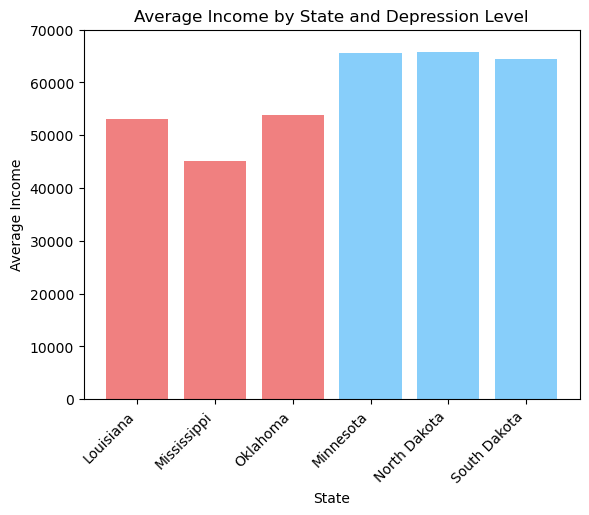

In [16]:
# Define colors based on Depression Level
colors = df_filtered_sorted['Depression and Anxiety Level'].map({'High': 'lightcoral', 'Low': 'lightskyblue'})

# Create a bar graph
plt.bar(df_filtered_sorted['State'], df_filtered_sorted['Average_Income'], color=colors)

# Set y-axis limits
plt.ylim(0, 70000)
plt.xticks(rotation=45, ha='right')

# Add labels and title
plt.xlabel('State')
plt.ylabel('Average Income')
plt.title('Average Income by State and Depression Level')

# Show the plot
plt.show()

In [17]:
csvpath = os.path.join("csv-data", "state_spending_data.csv")
df = pd.read_csv(csvpath) 
print(df.columns)



Index(['State', 'Total (in thousands)', 'Salaries and wages',
       'Employee benefits', 'Ratio of Salary to Benefits', 'Population'],
      dtype='object')


In [18]:
coi = ['Total (in thousands)', 'Salaries and wages', 'Employee benefits']
df_coi = df[['State'] + coi + ['Population']]
states_of_interest = ['Oklahoma', 'North Dakota', 'South Dakota', 'Mississippi', 'Minnesota', 'Louisiana']
df_filtered_coi = df_coi[df_coi.iloc[:, 0].isin(states_of_interest)].copy()
df_filtered_coi

,State,Total (in thousands),Salaries and wages,Employee benefits,Population
18,Louisiana,8294370,4150319,2111353,4573749
23,Minnesota,11984619,7193443,2524377,5737915
24,Mississippi,4489746,2642499,939780,2939690
34,North Dakota,1759225,1049140,402335,783926
36,Oklahoma,6470669,3564499,1242558,4053824
41,South Dakota,1544738,914918,261932,919318


In [19]:
# Add a new column "Depression Level" based on specified criteria
df_filtered_coi['Depression Level'] = df_filtered_coi['State'].apply(
    lambda x: 'High' if x in ['Louisiana', 'Mississippi', 'Oklahoma'] else 'Low'
)

# Sort the DataFrame by the new column
df_filtered_coi = df_filtered_coi.sort_values(by='Depression Level')

# Display the resulting DataFrame
df_filtered_coi

,State,Total (in thousands),Salaries and wages,Employee benefits,Population,Depression Level
18,Louisiana,8294370,4150319,2111353,4573749,High
24,Mississippi,4489746,2642499,939780,2939690,High
36,Oklahoma,6470669,3564499,1242558,4053824,High
23,Minnesota,11984619,7193443,2524377,5737915,Low
34,North Dakota,1759225,1049140,402335,783926,Low
41,South Dakota,1544738,914918,261932,919318,Low


In [20]:
columns_to_convert = ['Total (in thousands)', 'Salaries and wages', 'Employee benefits', 'Population']
df_filtered_coi[columns_to_convert] = df_filtered_coi[columns_to_convert].astype(int)

df_filtered_coi['total_per_capita_spending'] = df_filtered_coi['Total (in thousands)'] / df_filtered_coi['Population'] * 1000
df_filtered_coi['salary_per_capita_spending'] = df_filtered_coi['Salaries and wages'] / df_filtered_coi['Population'] * 1000
df_filtered_coi['benefits_per_capita_spending'] = df_filtered_coi['Employee benefits'] / df_filtered_coi['Population'] * 1000

df_filtered_coi

,State,Total (in thousands),Salaries and wages,Employee benefits,Population,Depression Level,total_per_capita_spending,salary_per_capita_spending,benefits_per_capita_spending
18,Louisiana,8294370,4150319,2111353,4573749,High,1813.472930,907.421680,461.624151
24,Mississippi,4489746,2642499,939780,2939690,High,1527.285530,898.903966,319.686770
36,Oklahoma,6470669,3564499,1242558,4053824,High,1596.188932,879.292984,306.515034
23,Minnesota,11984619,7193443,2524377,5737915,Low,2088.671408,1253.668449,439.946740
34,North Dakota,1759225,1049140,402335,783926,Low,2244.121256,1338.315096,513.230841
41,South Dakota,1544738,914918,261932,919318,Low,1680.308664,995.213843,284.919908


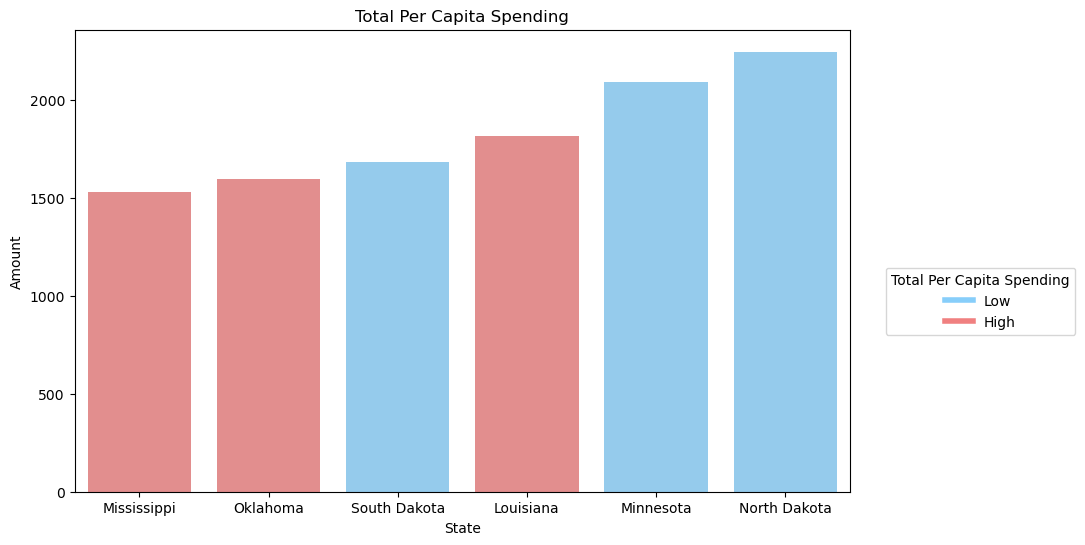

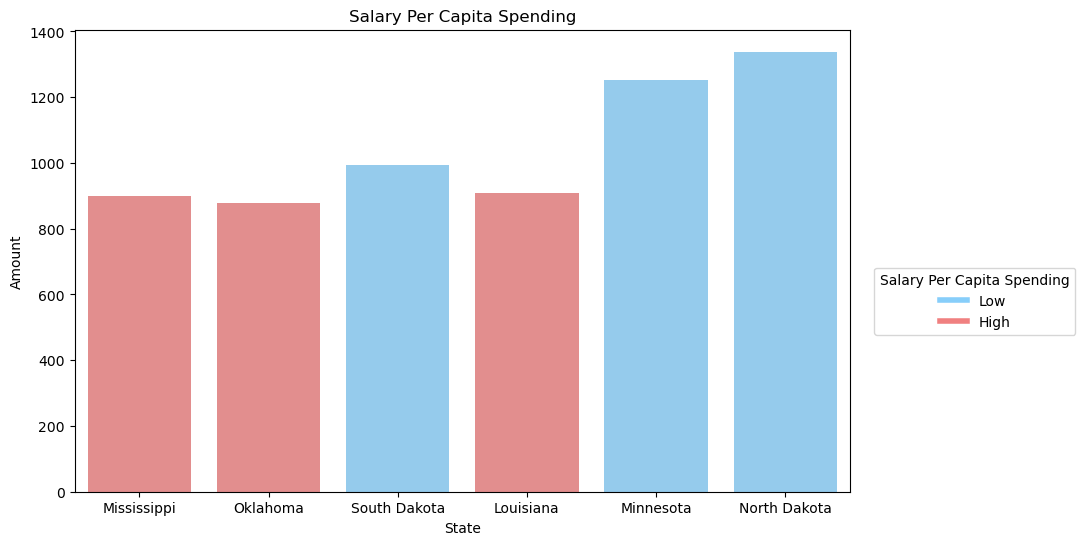

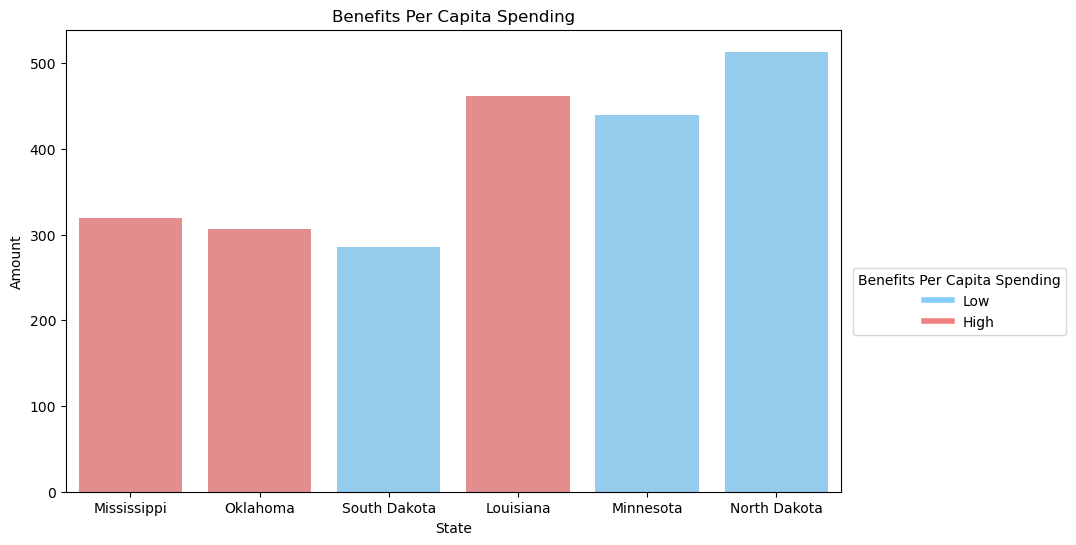

In [35]:
# # Create a DataFrame for plotting
# plot_df = df_filtered_coi.sort_values('total_per_capita_spending')
# colors = df_filtered_sorted['Depression and Anxiety Level'].map({'High': 'lightcoral', 'Low': 'lightskyblue'})

# # Plot total_per_capita_spending
# plt.figure(figsize=(10, 6))
# sns.barplot(x='State', y='total_per_capita_spending', data=plot_df, palette=colors)
# plt.title('Total Per Capita Spending')
# plt.ylabel('Amount')
# plt.legend(title='Total Per Capita Spending', labels=['Low', 'High'], loc='upper right')
# plt.show()

# # Plot salary_per_capita_spending
# plt.figure(figsize=(10, 6))
# sns.barplot(x='State', y='salary_per_capita_spending', data=plot_df, palette=colors)
# plt.title('Salary Per Capita Spending')
# plt.ylabel('Amount')
# plt.legend(title='Salary Per Capita Spending', labels=['Low', 'High'], loc='upper right')
# plt.show()

# # Plot benefits_per_capita_spending
# plt.figure(figsize=(10, 6))
# sns.barplot(x='State', y='benefits_per_capita_spending', data=plot_df, palette=colors)
# plt.title('Benefits Per Capita Spending')
# plt.ylabel('Amount')
# plt.legend(title='Benefits Per Capita Spending', labels=['Low', 'High'], loc='upper right')
# plt.show()

# Create a DataFrame for plotting
plot_df = df_filtered_coi.sort_values('total_per_capita_spending')

# Custom color mapping for specific states
state_colors = {
    'Louisiana': 'lightcoral',
    'Mississippi': 'lightcoral',
    'Oklahoma': 'lightcoral',
    'North Dakota': 'lightskyblue',
    'South Dakota': 'lightskyblue',
    'Minnesota': 'lightskyblue'
}

# Map the colors for the states
colors = plot_df['State'].map(state_colors).fillna('gray')

# Plot total_per_capita_spending
plt.figure(figsize=(10, 6))
sns.barplot(x='State', y='total_per_capita_spending', data=plot_df, palette=colors)
plt.title('Total Per Capita Spending')
plt.ylabel('Amount')
legend_labels = [plt.Line2D([0], [0], color='lightskyblue', lw=4),
                 plt.Line2D([0], [0], color='lightcoral', lw=4)]
plt.legend(legend_labels, ['Low', 'High'], title='Total Per Capita Spending', loc='upper right', bbox_to_anchor=(1.3, .5))
plt.show()

# Plot salary_per_capita_spending
plt.figure(figsize=(10, 6))
sns.barplot(x='State', y='salary_per_capita_spending', data=plot_df, palette=colors)
plt.title('Salary Per Capita Spending')
plt.ylabel('Amount')
legend_labels = [plt.Line2D([0], [0], color='lightskyblue', lw=4),
                 plt.Line2D([0], [0], color='lightcoral', lw=4)]
plt.legend(legend_labels, ['Low', 'High'], title='Salary Per Capita Spending', loc='upper right', bbox_to_anchor=(1.3, .5))
plt.show()

# Plot benefits_per_capita_spending
plt.figure(figsize=(10, 6))
sns.barplot(x='State', y='benefits_per_capita_spending', data=plot_df, palette=colors)
plt.title('Benefits Per Capita Spending')
plt.ylabel('Amount')
legend_labels = [plt.Line2D([0], [0], color='lightskyblue', lw=4),
                 plt.Line2D([0], [0], color='lightcoral', lw=4)]
plt.legend(legend_labels, ['Low', 'High'], title='Benefits Per Capita Spending', loc='upper right', bbox_to_anchor=(1.3, .5))
plt.show()

## Vicki

In [ ]:
csvpath_food = os.path.join("csv-data", "food-insecurity-data.csv")
dffood = pd.read_csv(csvpath_food)
dffood

In [ ]:
lad_states = ['South Dakota', 'Minnesota', 'North Dakota']
lad_states_food_insecurity = dffood[dffood['Area'].isin(lad_states)]
lad_states_food_insecurity.head()

In [ ]:
average_food_insecurity_minnesota = lad_states_food_insecurity.loc[lad_states_food_insecurity['Area'] == 'Minnesota', 'Percent - Percent Food Scarcity'].mean()
average_food_insecurity_minnesota = round(average_food_insecurity_minnesota, 2)
print(f"The average percent food insecurity for Minnesota is: {average_food_insecurity_minnesota}")

average_food_insecurity_north_dakota = lad_states_food_insecurity.loc[lad_states_food_insecurity['Area'] == 'North Dakota', 'Percent - Percent Food Scarcity'].mean()
average_food_insecurity_north_dakota = round(average_food_insecurity_north_dakota, 2)
print(f"The average percent food insecurity for North Dakota is: {average_food_insecurity_north_dakota}")

average_food_insecurity_south_dakota = lad_states_food_insecurity.loc[lad_states_food_insecurity['Area'] == 'South Dakota', 'Percent - Percent Food Scarcity'].mean()
average_food_insecurity_south_dakota = round(average_food_insecurity_south_dakota, 2)
print(f"The average percent food insecurity for South Dakota is: {average_food_insecurity_south_dakota}")

In [ ]:
had_states = ['Louisiana', 'Mississippi', 'Oklahoma']
had_states_food_insecurity = dffood[dffood['Area'].isin(had_states)]
had_states_food_insecurity.head()

In [ ]:
average_food_insecurity_louisiana = had_states_food_insecurity.loc[had_states_food_insecurity['Area'] == 'Louisiana', 'Percent - Percent Food Scarcity'].mean()
average_food_insecurity_louisiana = round(average_food_insecurity_louisiana, 2)
print(f"The average percent food insecurity for Louisiana is: {average_food_insecurity_louisiana}")

average_food_insecurity_mississippi = had_states_food_insecurity.loc[had_states_food_insecurity['Area'] == 'Mississippi', 'Percent - Percent Food Scarcity'].mean()
average_food_insecurity_mississippi = round(average_food_insecurity_mississippi, 2)
print(f"The average percent food insecurity for Mississippi is: {average_food_insecurity_mississippi}")

average_food_insecurity_oklahoma = had_states_food_insecurity.loc[had_states_food_insecurity['Area'] == 'Oklahoma', 'Percent - Percent Food Scarcity'].mean()
average_food_insecurity_oklahoma = round(average_food_insecurity_oklahoma, 2)
print(f"The average percent food insecurity for Oklahoma is: {average_food_insecurity_oklahoma}")

In [ ]:
# State names and their corresponding average food insecurity values
states = ['Minnesota', 'North Dakota', 'South Dakota', 'Louisiana', 'Mississippi', 'Oklahoma']
food_insecurity_values = [6.79, 8.57, 8.62, 14.88, 16.02, 12.55]

# Create a figure and axis object
fig, ax = plt.subplots()

# Define the width of each bar
bar_width = 0.5

# Set the positions for the bars
x = range(len(states))

# Plot the bars for the average food insecurity values
bars = ax.bar(x, food_insecurity_values, bar_width, label='Average Food Insecurity')

for i, state in enumerate(states):
    if state in ['North Dakota', 'South Dakota', 'Minnesota']:
        bars[i].set_color('lightskyblue')
    elif state in ['Louisiana', 'Mississippi', 'Oklahoma']:
        bars[i].set_color('lightcoral')

ax.set_xlabel('States')
ax.set_ylabel('Average Percent Food Insecurity')
ax.set_title('Average Percent Food Insecurity by State', y=1.05)  # Adjust title position
ax.set_xticks(x)
ax.set_xticklabels(states, rotation=35)




for i, bar in enumerate(bars):
    height = bar.get_height()
    ax.annotate('{}%'.format(food_insecurity_values[i]), xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  
                textcoords="offset points",
                ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [ ]:
csvpath_housing1 = os.path.join("csv-data", "weeks-1-12-housing-insecurity-data.csv")
dfhousing1 = pd.read_csv(csvpath_housing1)


In [ ]:
csvpath_housing2 = os.path.join("csv-data", "weeks-13-45-housing-insecurity-data.csv")
dfhousing2 = pd.read_csv(csvpath_housing2)


In [ ]:
merge_dfhousing = pd.merge(dfhousing1,dfhousing2, on = "Area")
merge_dfhousing

In [ ]:
lad_states = ['South Dakota', 'Minnesota', 'North Dakota']
lad_states_housing_insecurity = merge_dfhousing[merge_dfhousing['Area'].isin(lad_states)]
lad_states_housing_insecurity.head()

In [ ]:
average_housing_insecurity_minnesota = lad_states_housing_insecurity.loc[lad_states_housing_insecurity['Area'] == 'Minnesota', 'Percent - Percent Housing Insecurity (Missed Payment or Low Confidence)'].mean()
average_housing_insecurity_minnesota = round(average_housing_insecurity_minnesota, 2)
print(f"The average percent housing insecurity for Minnesota is: {average_housing_insecurity_minnesota}")
average_housing_insecurity_north_dakota = lad_states_housing_insecurity.loc[lad_states_housing_insecurity['Area'] == 'North Dakota', 'Percent - Percent Housing Insecurity (Missed Payment or Low Confidence)'].mean()
average_housing_insecurity_north_dakota = round(average_housing_insecurity_north_dakota, 2)
print(f"The average percent housing insecurity for North Dakota is: {average_housing_insecurity_north_dakota}")
average_housing_insecurity_south_dakota = lad_states_housing_insecurity.loc[lad_states_housing_insecurity['Area'] == 'South Dakota', 'Percent - Percent Housing Insecurity (Missed Payment or Low Confidence)'].mean()
average_housing_insecurity_south_dakota = round(average_housing_insecurity_south_dakota, 2)
print(f"The average percent housing insecurity for South Dakota is: {average_housing_insecurity_south_dakota}")

In [ ]:
had_states = ['Louisiana', 'Mississippi', 'Oklahoma']
had_states_housing_insecurity = merge_dfhousing[merge_dfhousing['Area'].isin(had_states)]
had_states_housing_insecurity.head()

In [ ]:
states = ['Minnesota', 'North Dakota', 'South Dakota', 'Louisiana', 'Mississippi', 'Oklahoma']
housing_insecurity_values = [14.77, 19.09, 20.36, 32.0, 36.61, 25.39]

fig, ax = plt.subplots()

bar_width = 0.5

x = range(len(states))

bars1 = ax.bar(x, housing_insecurity_values, bar_width, label='Average Housing Insecurity', edgecolor='none')  # Remove outline

for i, state in enumerate(states):
    if state in ['North Dakota', 'South Dakota', 'Minnesota']:
        bars1[i].set_color('lightskyblue')
    elif state in ['Louisiana', 'Mississippi', 'Oklahoma']:
        bars1[i].set_color('lightcoral')

ax.set_xlabel('States')
ax.set_ylabel('Average Percent Housing Insecurity')
ax.set_title('Average Percent Housing Insecurity by State', pad=20)  # Add padding to the title
ax.set_xticks(x)
ax.set_xticklabels(states, rotation=35)

for i, v in enumerate(housing_insecurity_values):
    ax.text(i, v + 0.5, f'{v:.2f}%', ha='center')  # Show percentages with 2 decimal places




plt.tight_layout()
plt.show()

## Victoria

In [ ]:
industries_csv = os.path.join("csv-data", "state_industry.csv")
raw_industries = pd.read_csv(industries_csv)
state_industries = raw_industries[(raw_industries['O_GROUP'] == 'major')]
state_industries.head()


In [ ]:
lad_states = ['South Dakota', 'Minnesota', 'North Dakota']
lad_states_industries = state_industries[state_industries['AREA_TITLE'].isin(lad_states)]
lad_states_industries = lad_states_industries.rename(columns={'OCC_TITLE': 'Occupation', 'H_MEDIAN': 'Median Hourly Wage', 'A_MEDIAN':'Median Annual Wage'})
lad_states_industries.head()

In [ ]:
had_states = ['Louisiana', 'Mississippi', 'Oklahoma']

had_states_industries = state_industries[state_industries['AREA_TITLE'].isin(had_states)]
had_states_industries = had_states_industries.rename(columns={'OCC_TITLE': 'Occupation', 'H_MEDIAN': 'Median Hourly Wage', 'A_MEDIAN':'Median Annual Wage'})

had_states_industries.head()

In [ ]:
south_dakota_rows = lad_states_industries.loc[lad_states_industries['AREA_TITLE'] == 'South Dakota', ['TOT_EMP']]
total_employment_south_dakota = south_dakota_rows['TOT_EMP'].astype(float).sum()
print(f'Total Employment in South Dakota: {total_employment_south_dakota}')

minnesota_rows = lad_states_industries.loc[lad_states_industries['AREA_TITLE'] == 'Minnesota', ['TOT_EMP']]
total_employment_minnesota= minnesota_rows['TOT_EMP'].astype(float).sum()
print(f'Total Employment in Minnesota: {total_employment_minnesota}')

north_dakota_rows = lad_states_industries.loc[lad_states_industries['AREA_TITLE'] == 'North Dakota', ['TOT_EMP']]
total_employment_north_dakota = north_dakota_rows['TOT_EMP'].astype(float).sum()
print(f'Total Employment in North Dakota: {total_employment_north_dakota}')



In [ ]:
louisiana_rows = had_states_industries.loc[had_states_industries['AREA_TITLE'] == 'Louisiana', ['TOT_EMP']]
total_employment_louisiana = louisiana_rows['TOT_EMP'].astype(float).sum()
print(f'Total Employment in Louisiana: {total_employment_louisiana}')

mississippi_rows = had_states_industries.loc[had_states_industries['AREA_TITLE'] == 'Mississippi', ['TOT_EMP']]
total_employment_mississippi = mississippi_rows['TOT_EMP'].astype(float).sum()
print(f'Total Employment in Mississippi: {total_employment_mississippi}')

oklahoma_rows = had_states_industries.loc[had_states_industries['AREA_TITLE'] == 'Oklahoma', ['TOT_EMP']]
total_employment_oklahoma = oklahoma_rows['TOT_EMP'].astype(float).sum()
print(f'Total Employment in Oklahoma: {total_employment_oklahoma}')


In [ ]:
south_dakota_industries = lad_states_industries.loc[lad_states_industries['AREA_TITLE'] == 'South Dakota', [ 'Occupation', 'TOT_EMP']]
minnesota_industries = lad_states_industries.loc[lad_states_industries['AREA_TITLE'] == 'Minnesota', [ 'Occupation', 'TOT_EMP']]
north_dakota_industries = lad_states_industries.loc[lad_states_industries['AREA_TITLE'] == 'North Dakota', [ 'Occupation', 'TOT_EMP']]

In [ ]:
south_dakota_industries['TOT_EMP'] = pd.to_numeric(south_dakota_industries['TOT_EMP'], errors='coerce')
south_dakota_industries['PERCENT_OF_EMPLOYEES'] = south_dakota_industries['TOT_EMP'] / total_employment_south_dakota

minnesota_industries['TOT_EMP'] = pd.to_numeric(minnesota_industries['TOT_EMP'], errors='coerce')
minnesota_industries['PERCENT_OF_EMPLOYEES'] = minnesota_industries['TOT_EMP'] / total_employment_minnesota

north_dakota_industries['TOT_EMP'] = pd.to_numeric(north_dakota_industries['TOT_EMP'], errors='coerce')
north_dakota_industries['PERCENT_OF_EMPLOYEES'] = north_dakota_industries['TOT_EMP'] / total_employment_north_dakota


In [ ]:
merged_data = pd.merge(south_dakota_industries[['Occupation', 'PERCENT_OF_EMPLOYEES']],
                       minnesota_industries[['Occupation', 'PERCENT_OF_EMPLOYEES']],
                       on='Occupation', how='outer', suffixes=('_SD', '_MN'))

merged_data = merged_data.rename(columns={'PERCENT_OF_EMPLOYEES_SD': '% of Employees SD', 'PERCENT_OF_EMPLOYEES_MN' : 
                                         '% of Employees MN'})


merged_data = pd.merge(merged_data,
                       north_dakota_industries[['Occupation', 'PERCENT_OF_EMPLOYEES']],
                       on='Occupation', how='outer', suffixes=('_MN', '_ND'))
merged_data = merged_data.rename(columns={'PERCENT_OF_EMPLOYEES': '% of Employees ND',})


percentage_columns = ['% of Employees SD', '% of Employees MN', '% of Employees ND']
merged_data[percentage_columns] = merged_data[percentage_columns].apply(lambda x: x * 100)
merged_data[percentage_columns] = merged_data[percentage_columns].applymap(lambda x: f'{x:.2f}%')

occupation_percentage_lad = merged_data
occupation_percentage_lad

In [ ]:
occupation_percentage_lad['% of Employees SD'] = occupation_percentage_lad['% of Employees SD'].astype(str)
occupation_percentage_lad['% of Employees MN'] = occupation_percentage_lad['% of Employees MN'].astype(str)
occupation_percentage_lad['% of Employees ND'] = occupation_percentage_lad['% of Employees ND'].astype(str)

occupation_percentage_lad['% of Employees SD'] = pd.to_numeric(occupation_percentage_lad['% of Employees SD'].str.rstrip('%'), errors='coerce')
occupation_percentage_lad['% of Employees MN'] = pd.to_numeric(occupation_percentage_lad['% of Employees MN'].str.rstrip('%'), errors='coerce')
occupation_percentage_lad['% of Employees ND'] = pd.to_numeric(occupation_percentage_lad['% of Employees ND'].str.rstrip('%'), errors='coerce')

top_occupations_SD = occupation_percentage_lad.nlargest(5, '% of Employees SD')[['Occupation', '% of Employees SD']]
top_occupations_MN = occupation_percentage_lad.nlargest(5, '% of Employees MN')[['Occupation', '% of Employees MN']]
top_occupations_ND = occupation_percentage_lad.nlargest(5, '% of Employees ND')[['Occupation', '% of Employees ND']]


In [ ]:
# Display the top_occupations_sd dataframe
print("Top Occupations in South Dakota")
display(top_occupations_SD)

# Display the top_occupations_mn dataframe
print("Top Occupations in Minnesota")
display(top_occupations_MN)

# Display the top_occupations_nd dataframe
print("Top Occupations in North Dakota")
display(top_occupations_ND)

In [ ]:
wages_top_occupations_SD = pd.merge(top_occupations_SD,
                                     lad_states_industries.loc[lad_states_industries['AREA_TITLE'] == 'South Dakota'],
                                     on='Occupation', how='left')[['Occupation', '% of Employees SD', 'Median Hourly Wage', 'Median Annual Wage']]

wages_top_occupations_MN = pd.merge(top_occupations_MN,
                                     lad_states_industries.loc[lad_states_industries['AREA_TITLE'] == 'Minnesota'],
                                     on='Occupation', how='left')[['Occupation', '% of Employees MN', 'Median Hourly Wage', 'Median Annual Wage']]



wages_top_occupations_ND = pd.merge(top_occupations_ND,
                                     lad_states_industries.loc[lad_states_industries['AREA_TITLE'] == 'North Dakota'],
                                     on='Occupation', how='left')[['Occupation', '% of Employees ND', 'Median Hourly Wage', 'Median Annual Wage']]



In [ ]:
print("Wages of the Top Occupations in South Dakota")
display(wages_top_occupations_SD )

# Display the top_occupations_mn dataframe
print("Wages of Top Occupations in Minnesota")
display(wages_top_occupations_MN)

# Display the top_occupations_nd dataframe
print("Top Occupations in North Dakota")
display(wages_top_occupations_ND)

In [ ]:
def plot_state_graph(ax, state_df, state_name, color):
    state_df['Median Annual Wage'] = state_df['Median Annual Wage'].replace('[\$,]', '', regex=True).astype(float)
    filtered_data = state_df.dropna(subset=['Median Annual Wage'])
    sorted_data = filtered_data.sort_values(by='Median Annual Wage', ascending=False)

    ticks = range(len(sorted_data['Occupation']))
    ax.set_xticks(ticks)
    ax.set_xticklabels(sorted_data['Occupation'], rotation=45, ha='right')

    ax.bar(ticks, sorted_data['Median Annual Wage'], color=color)
    ax.set_xlabel('Occupation')
    ax.set_ylabel('Median Annual Wage')
    ax.set_title(f'Median Annual Wage for Top Occupations in {state_name}')
    ax.set_ylim(0, 65000)

fig, axes = plt.subplots(3, 1, figsize=(8, 20))

plot_state_graph(axes[0], wages_top_occupations_SD, 'South Dakota', 'lightblue')

plot_state_graph(axes[1], wages_top_occupations_MN, 'Minnesota', 'lightblue')

plot_state_graph(axes[2], wages_top_occupations_ND, 'North Dakota', 'lightblue')

plt.tight_layout()
plt.show()

In [ ]:
louisiana_industries = had_states_industries.loc[had_states_industries['AREA_TITLE'] == 'Louisiana', [ 'Occupation', 'TOT_EMP']]
mississippi_industries = had_states_industries.loc[had_states_industries['AREA_TITLE'] == 'Mississippi', [ 'Occupation', 'TOT_EMP']]
oklahoma_industries = had_states_industries.loc[had_states_industries['AREA_TITLE'] == 'Oklahoma', [ 'Occupation', 'TOT_EMP']]

In [ ]:
louisiana_industries['TOT_EMP'] = pd.to_numeric(louisiana_industries['TOT_EMP'], errors='coerce')
louisiana_industries['PERCENT_OF_EMPLOYEES'] = louisiana_industries['TOT_EMP'] / total_employment_louisiana

mississippi_industries['TOT_EMP'] = pd.to_numeric(mississippi_industries['TOT_EMP'], errors='coerce')
mississippi_industries['PERCENT_OF_EMPLOYEES'] = mississippi_industries['TOT_EMP'] / total_employment_mississippi

oklahoma_industries['TOT_EMP'] = pd.to_numeric(oklahoma_industries['TOT_EMP'], errors='coerce')
oklahoma_industries['PERCENT_OF_EMPLOYEES'] = oklahoma_industries['TOT_EMP'] / total_employment_oklahoma

In [ ]:
merged_data = pd.merge(louisiana_industries[['Occupation', 'PERCENT_OF_EMPLOYEES']],
                       mississippi_industries[['Occupation', 'PERCENT_OF_EMPLOYEES']],
                       on='Occupation', how='outer', suffixes=('_LA', '_MS'))

merged_data = merged_data.rename(columns={'PERCENT_OF_EMPLOYEES_LA': '% of Employees LA', 'PERCENT_OF_EMPLOYEES_MS' : 
                                         '% of Employees MS'})


merged_data = pd.merge(merged_data,
                       oklahoma_industries[['Occupation', 'PERCENT_OF_EMPLOYEES']],
                       on='Occupation', how='outer', suffixes=('_MS', '_OK'))
merged_data = merged_data.rename(columns={'PERCENT_OF_EMPLOYEES': '% of Employees OK',})


percentage_columns = ['% of Employees LA', '% of Employees MS', '% of Employees OK']
merged_data[percentage_columns] = merged_data[percentage_columns].apply(lambda x: x * 100)
merged_data[percentage_columns] = merged_data[percentage_columns].applymap(lambda x: f'{x:.2f}%')

occupation_percentage_had = merged_data
occupation_percentage_had

In [ ]:
occupation_percentage_had['% of Employees LA'] = occupation_percentage_had['% of Employees LA'].astype(str)
occupation_percentage_had['% of Employees MS'] = occupation_percentage_had['% of Employees MS'].astype(str)
occupation_percentage_had['% of Employees OK'] = occupation_percentage_had['% of Employees OK'].astype(str)

occupation_percentage_had['% of Employees LA'] = pd.to_numeric(occupation_percentage_had['% of Employees LA'].str.rstrip('%'), errors='coerce')
occupation_percentage_had['% of Employees MS'] = pd.to_numeric(occupation_percentage_had['% of Employees MS'].str.rstrip('%'), errors='coerce')
occupation_percentage_had['% of Employees OK'] = pd.to_numeric(occupation_percentage_had['% of Employees OK'].str.rstrip('%'), errors='coerce')

top_occupations_LA = occupation_percentage_had.nlargest(5, '% of Employees LA')[['Occupation', '% of Employees LA']]
top_occupations_MS = occupation_percentage_had.nlargest(5, '% of Employees MS')[['Occupation', '% of Employees MS']]
top_occupations_OK = occupation_percentage_had.nlargest(5, '% of Employees OK')[['Occupation', '% of Employees OK']]


In [ ]:
print("Top Occupations in Louisiana")
display(top_occupations_LA)

print("Top Occupations in Mississippi")
display(top_occupations_MS)

print("Top Occupations in Oklahoma")
display(top_occupations_OK)

In [ ]:
wages_top_occupations_LA = pd.merge(top_occupations_LA,
                                     had_states_industries.loc[had_states_industries['AREA_TITLE'] == 'Louisiana'],
                                     on='Occupation', how='left')[['Occupation', '% of Employees LA', 'Median Hourly Wage', 'Median Annual Wage']]

wages_top_occupations_MS = pd.merge(top_occupations_MS,
                                     had_states_industries.loc[had_states_industries['AREA_TITLE'] == 'Mississippi'],
                                     on='Occupation', how='left')[['Occupation', '% of Employees MS', 'Median Hourly Wage', 'Median Annual Wage']]

wages_top_occupations_OK = pd.merge(top_occupations_OK,
                                     had_states_industries.loc[had_states_industries['AREA_TITLE'] == 'Oklahoma'],
                                     on='Occupation', how='left')[['Occupation', '% of Employees OK', 'Median Hourly Wage', 'Median Annual Wage']]





In [ ]:
print("Wages of the Top Occupations in Louisiana")
display(wages_top_occupations_LA)

print("Top Occupations in Mississippi")
display(wages_top_occupations_MS)

print("Top Occupations in Oklahoma")
display(wages_top_occupations_OK)

In [ ]:
def plot_state_graph(ax, state_df, state_name, color):
    state_df['Median Annual Wage'] = state_df['Median Annual Wage'].replace('[\$,]', '', regex=True).astype(float)
    filtered_data = state_df.dropna(subset=['Median Annual Wage'])
    sorted_data = filtered_data.sort_values(by='Median Annual Wage', ascending=False)

    # Set ticks and labels
    ticks = range(len(sorted_data['Occupation']))
    ax.set_xticks(ticks)
    ax.set_xticklabels(sorted_data['Occupation'], rotation=45, ha='right')

    ax.bar(ticks, sorted_data['Median Annual Wage'], color=color)
    ax.set_xlabel('Occupation')
    ax.set_ylabel('Median Annual Wage')
    ax.set_title(f'Median Annual Wage for Top Occupations in {state_name}')
    ax.set_ylim(0, 65000)

# Create subplots (3 rows, 1 column)
fig, axes = plt.subplots(3, 1, figsize=(8, 20))

# Plot for Louisiana
plot_state_graph(axes[0], wages_top_occupations_LA, 'Louisiana', 'lightcoral')

# Plot for Mississippi
plot_state_graph(axes[1], wages_top_occupations_MS, 'Mississippi', 'lightcoral')

# Plot for Oklahoma
plot_state_graph(axes[2], wages_top_occupations_OK, 'Oklahoma', 'lightcoral')

# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
states_data = {
    'South Dakota': wages_top_occupations_SD,
    'Minnesota': wages_top_occupations_MN,
    'North Dakota': wages_top_occupations_ND,
    'Louisiana': wages_top_occupations_LA,
    'Mississippi': wages_top_occupations_MS,
    'Oklahoma': wages_top_occupations_OK,
}

colors = {
    'South Dakota': 'lightblue',
    'Minnesota': 'lightblue',
    'North Dakota': 'lightblue',
    'Louisiana': 'lightcoral',
    'Mississippi': 'lightcoral',
    'Oklahoma': 'lightcoral',
}

plt.figure(figsize=(10, 6))

for state, df in states_data.items():
    row_data = df[df['Occupation'] == 'Office and Administrative Support Occupations']
    plt.barh(state, row_data['Median Annual Wage'].values[0], color=colors[state])

plt.xlim(0, 60000)
plt.title('Median Annual Wage for Office and Administrative Support Occupations')
plt.xlabel('Median Annual Wage')
plt.ylabel('State')

# Show the plot
plt.show()

In [ ]:
import matplotlib.pyplot as plt

states_data = {
    'South Dakota': wages_top_occupations_SD,
    'Minnesota': wages_top_occupations_MN,
    'North Dakota': wages_top_occupations_ND,
    'Louisiana': wages_top_occupations_LA,
    'Mississippi': wages_top_occupations_MS,
    'Oklahoma': wages_top_occupations_OK,
}

colors = {
    'South Dakota': 'lightblue',
    'Minnesota': 'lightblue',
    'North Dakota': 'lightblue',
    'Louisiana': 'lightcoral',
    'Mississippi': 'lightcoral',
    'Oklahoma': 'lightcoral',
}

plt.figure(figsize=(10, 6))

for state, df in states_data.items():
    row_data = df[df['Occupation'] == "Sales and Related Occupations"]
    plt.barh(state, row_data['Median Annual Wage'].values[0], color=colors[state])

plt.xlim(0, 50000)
plt.title(f'Median Annual Wage for {"Sales and Related Occupations"} in Different States')
plt.ylabel('State')
plt.xlabel('Median Annual Wage')

# Show the plot
plt.show()


In [ ]:
states_data = {
    'South Dakota': wages_top_occupations_SD,
    'Minnesota': wages_top_occupations_MN,
    'North Dakota': wages_top_occupations_ND,
    'Louisiana': wages_top_occupations_LA,
    'Mississippi': wages_top_occupations_MS,
    'Oklahoma': wages_top_occupations_OK,
}

colors = {
    'South Dakota': 'lightblue',
    'Minnesota': 'lightblue',
    'North Dakota': 'lightblue',
    'Louisiana': 'lightcoral',
    'Mississippi': 'lightcoral',
    'Oklahoma': 'lightcoral',
}

plt.figure(figsize=(10, 6))

for state, df in states_data.items():
    row_data = df[df['Occupation'] == "Food Preparation and Serving Related Occupations"]
    plt.barh(state, row_data['Median Annual Wage'].values[0], color=colors[state])

plt.xlim(0, 50000)
plt.title(f'Median Annual Wage for {"Food Preparation and Serving Related Occupations"} in Different States')
plt.ylabel('State')
plt.xlabel('Median Annual Wage')

# Show the plot
plt.show()

In [ ]:
disconnected_youth_csv = r'C:\Users\vjmar\Desktop\DataScience\blue-team-project-1\csv-data\disconnected_youth.csv'
disconnected_youth_raw = pd.read_csv(disconnected_youth_csv)
disconnected_youth_raw.head()


In [ ]:
lad_states = ['South Dakota', 'Minnesota', 'North Dakota']

disconnected_youth_raw['TimeFrame'] = disconnected_youth_raw['TimeFrame'].astype(int)

disconnected_youth_lad_states = disconnected_youth_raw[
    (disconnected_youth_raw['TimeFrame'] == 2022) & 
    (disconnected_youth_raw['Location'].isin(lad_states) &
    (disconnected_youth_raw['DataFormat'] == 'Percent') &
    (disconnected_youth_raw['Age group'] == '16 to 24'))
]

disconnected_youth_lad_states['Data'] = disconnected_youth_lad_states['Data'].str.rstrip('%').astype(float)
disconnected_youth_lad_states['Data'] = round(disconnected_youth_lad_states['Data'] * 100).astype(int)

disconnected_youth_lad_states

In [ ]:

had_states = ['Louisiana', 'Mississippi', 'Oklahoma']

disconnected_youth_raw['TimeFrame'] = disconnected_youth_raw['TimeFrame'].astype(int)

disconnected_youth_had_states = disconnected_youth_raw[
    (disconnected_youth_raw['TimeFrame'] == 2022) & 
    (disconnected_youth_raw['Location'].isin(had_states) &
    (disconnected_youth_raw['DataFormat'] == 'Percent') &
    (disconnected_youth_raw['Age group'] == '16 to 24'))
]
disconnected_youth_had_states['Data'] = disconnected_youth_had_states['Data'].str.rstrip('%').astype(float)
disconnected_youth_had_states['Data'] = round(disconnected_youth_had_states['Data'] * 100).astype(int)


disconnected_youth_had_states

In [ ]:
plt.barh(disconnected_youth_had_states['Location'], disconnected_youth_had_states['Data'], color='lightcoral', alpha=0.7)

plt.barh(disconnected_youth_lad_states['Location'], disconnected_youth_lad_states['Data'], color='skyblue', alpha=0.7)

plt.xlabel('Percent of Youth')
plt.ylabel('State')
plt.title('Percent of Youth Ages 16-24 Not in Education or Employment')

plt.show()


In [ ]:
employment_csv = r'C:\Users\vjmar\Desktop\DataScience\blue-team-project-1\csv-data\employment_data.csv'
employment_data_raw = pd.read_csv(employment_csv)
employment_data_raw.head()


In [ ]:
columns_to_select = [
    'Geographic Area Name',
    'Estimate!!EMPLOYMENT STATUS!!Population 16 years and over',
    'Estimate!!EMPLOYMENT STATUS!!Population 16 years and over!!In labor force!!Civilian labor force',
    'Estimate!!EMPLOYMENT STATUS!!Population 16 years and over!!In labor force!!Civilian labor force!!Employed',
    'Estimate!!EMPLOYMENT STATUS!!Population 16 years and over!!In labor force!!Civilian labor force!!Unemployed',
    'Estimate!!EMPLOYMENT STATUS!!Population 16 years and over!!In labor force!!Armed Forces',
    'Estimate!!EMPLOYMENT STATUS!!Population 16 years and over!!Not in labor force'
]

employment_data_selected = employment_data_raw.filter(items=columns_to_select)

employment_data_selected = employment_data_selected.rename(columns={
    'Geographic Area Name': 'State',
    'Estimate!!EMPLOYMENT STATUS!!Population 16 years and over': 'Population 16+',
    'Estimate!!EMPLOYMENT STATUS!!Population 16 years and over!!In labor force!!Civilian labor force': 'Population 16+ in Civilian Labor Force',
    'Estimate!!EMPLOYMENT STATUS!!Population 16 years and over!!In labor force!!Civilian labor force!!Employed': 'Employed Population 16+ in Civilian Labor Force',
    'Estimate!!EMPLOYMENT STATUS!!Population 16 years and over!!In labor force!!Civilian labor force!!Unemployed': 'Unemployed Population 16+ in Civilian Labor Force',
    'Estimate!!EMPLOYMENT STATUS!!Population 16 years and over!!In labor force!!Armed Forces': 'Population 16+ in Armed Forces',
    'Estimate!!EMPLOYMENT STATUS!!Population 16 years and over!!Not in labor force': 'Population 16+ Not in Labor Force'

})

employment_data_selected




In [ ]:
south_dakota_data = employment_data_selected[employment_data_selected['State'] == 'South Dakota']
minnesota_data = employment_data_selected[employment_data_selected['State'] == 'Minnesota']
north_dakota_data = employment_data_selected[employment_data_selected['State'] == 'North Dakota']

unemployed_labor_force_sd = south_dakota_data['Unemployed Population 16+ in Civilian Labor Force'].values[0]
civilian_labor_force_sd = south_dakota_data['Population 16+ in Civilian Labor Force'].values[0]
unemployment_sd = (unemployed_labor_force_sd / civilian_labor_force_sd) * 100

unemployed_labor_force_mn = minnesota_data['Unemployed Population 16+ in Civilian Labor Force'].values[0]
civilian_labor_force_mn = minnesota_data['Population 16+ in Civilian Labor Force'].values[0]
unemployment_mn = (unemployed_labor_force_mn / civilian_labor_force_mn) * 100

unemployed_labor_force_nd = north_dakota_data['Unemployed Population 16+ in Civilian Labor Force'].values[0]
civilian_labor_force_nd = north_dakota_data['Population 16+ in Civilian Labor Force'].values[0]
unemployment_nd = (unemployed_labor_force_nd / civilian_labor_force_nd) * 100


In [ ]:
south_dakota_data = employment_data_selected[employment_data_selected['State'] == 'South Dakota']
minnesota_data = employment_data_selected[employment_data_selected['State'] == 'Minnesota']
north_dakota_data = employment_data_selected[employment_data_selected['State'] == 'North Dakota']

not_in_labor_force_sd = south_dakota_data['Population 16+ Not in Labor Force'].values[0]
population_16_plus_sd = south_dakota_data['Population 16+'].values[0]
out_of_labor_force_sd = (not_in_labor_force_sd / population_16_plus_sd) * 100

not_in_labor_force_mn = minnesota_data['Population 16+ Not in Labor Force'].values[0]
population_16_plus_mn = minnesota_data['Population 16+'].values[0]
out_of_labor_force_mn = (not_in_labor_force_mn / population_16_plus_mn) * 100

not_in_labor_force_nd = north_dakota_data['Population 16+ Not in Labor Force'].values[0]
population_16_plus_nd = north_dakota_data['Population 16+'].values[0]
out_of_labor_force_nd = (not_in_labor_force_nd / population_16_plus_nd) * 100



In [ ]:
louisiana_data = employment_data_selected[employment_data_selected['State'] == 'Louisiana']
mississippi_data = employment_data_selected[employment_data_selected['State'] == 'Mississippi']
oklahoma_data = employment_data_selected[employment_data_selected['State'] == 'Oklahoma']

not_in_labor_force_la = louisiana_data['Population 16+ Not in Labor Force'].values[0]
population_16_plus_la = louisiana_data['Population 16+'].values[0]
out_of_labor_force_la = (not_in_labor_force_la / population_16_plus_la) * 100

not_in_labor_force_ms = mississippi_data['Population 16+ Not in Labor Force'].values[0]
population_16_plus_ms = mississippi_data['Population 16+'].values[0]
out_of_labor_force_ms = (not_in_labor_force_ms / population_16_plus_ms) * 100

not_in_labor_force_ok = oklahoma_data['Population 16+ Not in Labor Force'].values[0]
population_16_plus_ok = oklahoma_data['Population 16+'].values[0]
out_of_labor_force_ok = (not_in_labor_force_ok / population_16_plus_ok) * 100


In [ ]:
louisiana_data = employment_data_selected[employment_data_selected['State'] == 'Louisiana']
oklahoma_data = employment_data_selected[employment_data_selected['State'] == 'Oklahoma']
mississippi_data = employment_data_selected[employment_data_selected['State'] == 'Mississippi']

unemployed_labor_force_la = louisiana_data['Unemployed Population 16+ in Civilian Labor Force'].values[0]
civilian_labor_force_la = louisiana_data['Population 16+ in Civilian Labor Force'].values[0]
unemployment_la = (unemployed_labor_force_la / civilian_labor_force_la) * 100

unemployed_labor_force_ok = oklahoma_data['Unemployed Population 16+ in Civilian Labor Force'].values[0]
civilian_labor_force_ok = oklahoma_data['Population 16+ in Civilian Labor Force'].values[0]
unemployment_ok = (unemployed_labor_force_ok / civilian_labor_force_ok) * 100

unemployed_labor_force_ms = mississippi_data['Unemployed Population 16+ in Civilian Labor Force'].values[0]
civilian_labor_force_ms = mississippi_data['Population 16+ in Civilian Labor Force'].values[0]
unemployment_ms = (unemployed_labor_force_ms / civilian_labor_force_ms) * 100


In [ ]:
lad_states = ['South Dakota', 'Minnesota', 'North Dakota']
out_of_labor_force_lad_states = [out_of_labor_force_sd, out_of_labor_force_mn, out_of_labor_force_nd]

had_states = ['Louisiana', 'Mississippi', 'Oklahoma']
out_of_labor_force_had_states = [out_of_labor_force_la, out_of_labor_force_ms, out_of_labor_force_ok]

plt.figure(figsize=(10, 6))

plt.barh(had_states, out_of_labor_force_had_states, label='LA, OK, MS', color='coral', alpha=0.7)
plt.barh(lad_states, out_of_labor_force_lad_states, label='SD, MN, ND', color='skyblue', alpha=0.7)


plt.title('Percent of People 16+ Not in Labor Force')
plt.xlabel('Percent of People 16+')
plt.ylabel('States')

plt.show()

In [ ]:
lad_states = ['South Dakota', 'Minnesota', 'North Dakota']
unemployed_lad_states = [unemployment_sd, unemployment_mn, unemployment_nd]

had_states = ['Louisiana', 'Mississippi', 'Oklahoma']
unemployed_had_states = [unemployment_la, unemployment_ms, unemployment_ok]

plt.figure(figsize=(10, 6))

plt.barh(had_states, unemployed_had_states, label='LA, OK, MS', color='coral', alpha=0.7)
plt.barh(lad_states, unemployed_lad_states, label='SD, MN, ND', color='skyblue', alpha=0.7)


plt.title('Percent of Unemployed People 16+ in the Labor Force')
plt.xlabel('Percent of People 16+')
plt.ylabel('States')

plt.show()